# Dacon_Jeju Bus Prediction 

### 데이터 명세

- id : 해당 데이터의 고유한 ID (train, test와의 중복은 없음)

- date  : 날짜

- bus_route_id : 노선 id

- in_out  : 시내버스, 시외버스 구분 (categorical)

- station_code : 해당 승하차 정류소의 ID

- station_name : 해당 승하차 정류소의 이름

- latitude : 해당 버스 정류장의 위도 

- longitude : 해당 버스 정류장의 경도 
##### *** 같은 위도경도여도 진행 방향에 따라 정류장이 다를수 있음.

- X-Y ride : 00:00부터 59:59까지 승차한 인원수

- X-Y takeoff : 00:00부터 59:59까지 하차한 인원수

- 18-20 ride : 18:00:00부터 19:59:59까지 승차한 인원 수 (train data에만 존재, 예측해야할 target) 


# 0. Data Load

In [1]:
import numpy as np #데이터 처리
import pandas as pd #데이터 처리

import missingno as msno # 결측값 유무 시각화
import warnings
warnings.filterwarnings('ignore')
from collections import Counter # count 용도

import matplotlib.pyplot as plt # 시각화
import seaborn as sns #시각화

import folium # 지도 관련 시각화pip 
from folium.plugins import MarkerCluster #지도 관련 시각화
import geopy.distance #거리 계산해주는 패키지 사용

import random #데이터 샘플링
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV 


from sklearn.ensemble import RandomForestRegressor #모델링
import lightgbm as lgbm #모델링

from tqdm import tqdm_notebook

C:\Users\Kim\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv("버스승차예측/train.csv")
test = pd.read_csv("버스승차예측/test.csv")
weather = pd.read_csv('jeju_weather_dataset', encoding='cp949')

In [3]:
weather.columns

Index(['지점', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)',
       '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)',
       '운형(운형약어)', '최저운고(100m )', '시정(10m)', '지면상태(지면상태코드)', '현상번호(국내식)',
       '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)'],
      dtype='object')

In [4]:
weather = weather[['일시','강수량(mm)', '기온(°C)']]
weather.columns = ['date','precipitation','temp']

In [5]:
weather

,date,precipitation,temp
0,2019-01-01 00:00,NaN,5.1
1,2019-01-01 01:00,NaN,5.2
2,2019-01-01 02:00,NaN,5.7
3,2019-01-01 03:00,NaN,5.8
4,2019-01-01 04:00,NaN,6.1
...,...,...,...
8755,2019-12-31 19:00,NaN,2.4
8756,2019-12-31 20:00,NaN,2.4
8757,2019-12-31 21:00,NaN,2.3
8758,2019-12-31 22:00,NaN,2.4


# 1. EDA

In [6]:
#구조 파악
train.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [7]:
test.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [8]:
train.shape # 415423행 21열
test.shape # 228170행 20열

(228170, 20)

In [9]:
#두 데이터 컬럼 비교 
train.columns.difference(test.columns) #'18~20_ride' => target

Index(['18~20_ride'], dtype='object')

In [10]:
# train / test 날짜 범위 비교
train['date'].agg(['min','max']) #2019-09-01 ~ 2019-09-30
test['date'].agg(['min','max']) #2019-10-01 ~ 2019-10-16

min    2019-10-01
max    2019-10-16
Name: date, dtype: object

Text(0.5, 1.0, 'Distribution of date in Train-set')

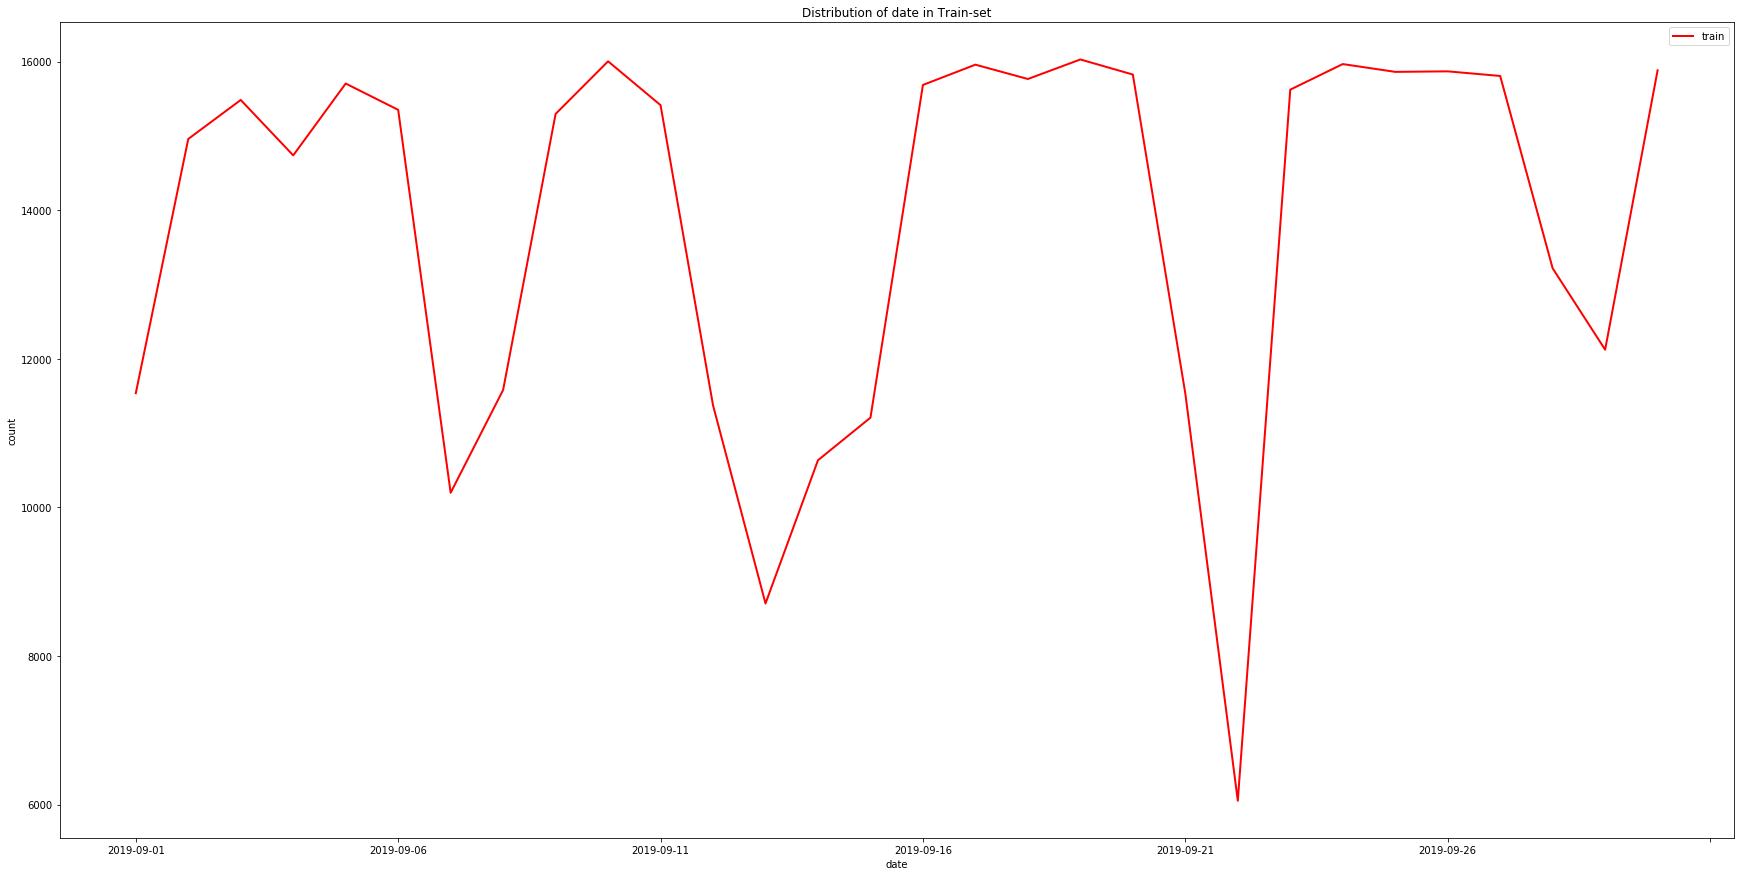

In [11]:
plt.figure(figsize=(30,15))
train['date'].value_counts().sort_index().plot(color="r", lw=2, label='train')
plt.legend() #label 표시
plt.xlabel("date") #x축 label
plt.ylabel("count") #y축 label
plt.title("Distribution of date in Train-set")

# 날짜의 갯수가 날 마다 다른것을 보았을때 승차인원이 없거나하면 표기가 안된다? Yes.

# Dacon 데이터 설명 중>
# 버스에서 하차를 할 때, 버스카드를 찍지 않는 경우, 해당 기록이 비어 있는 상태입니다. 
# 따라서, 승차 인원수와 하차 인원수가 동일하지 않고 다소 차이가 있음을 미리 알려드립니다.

Text(0.5, 1.0, 'Distribution of date in Train-set')

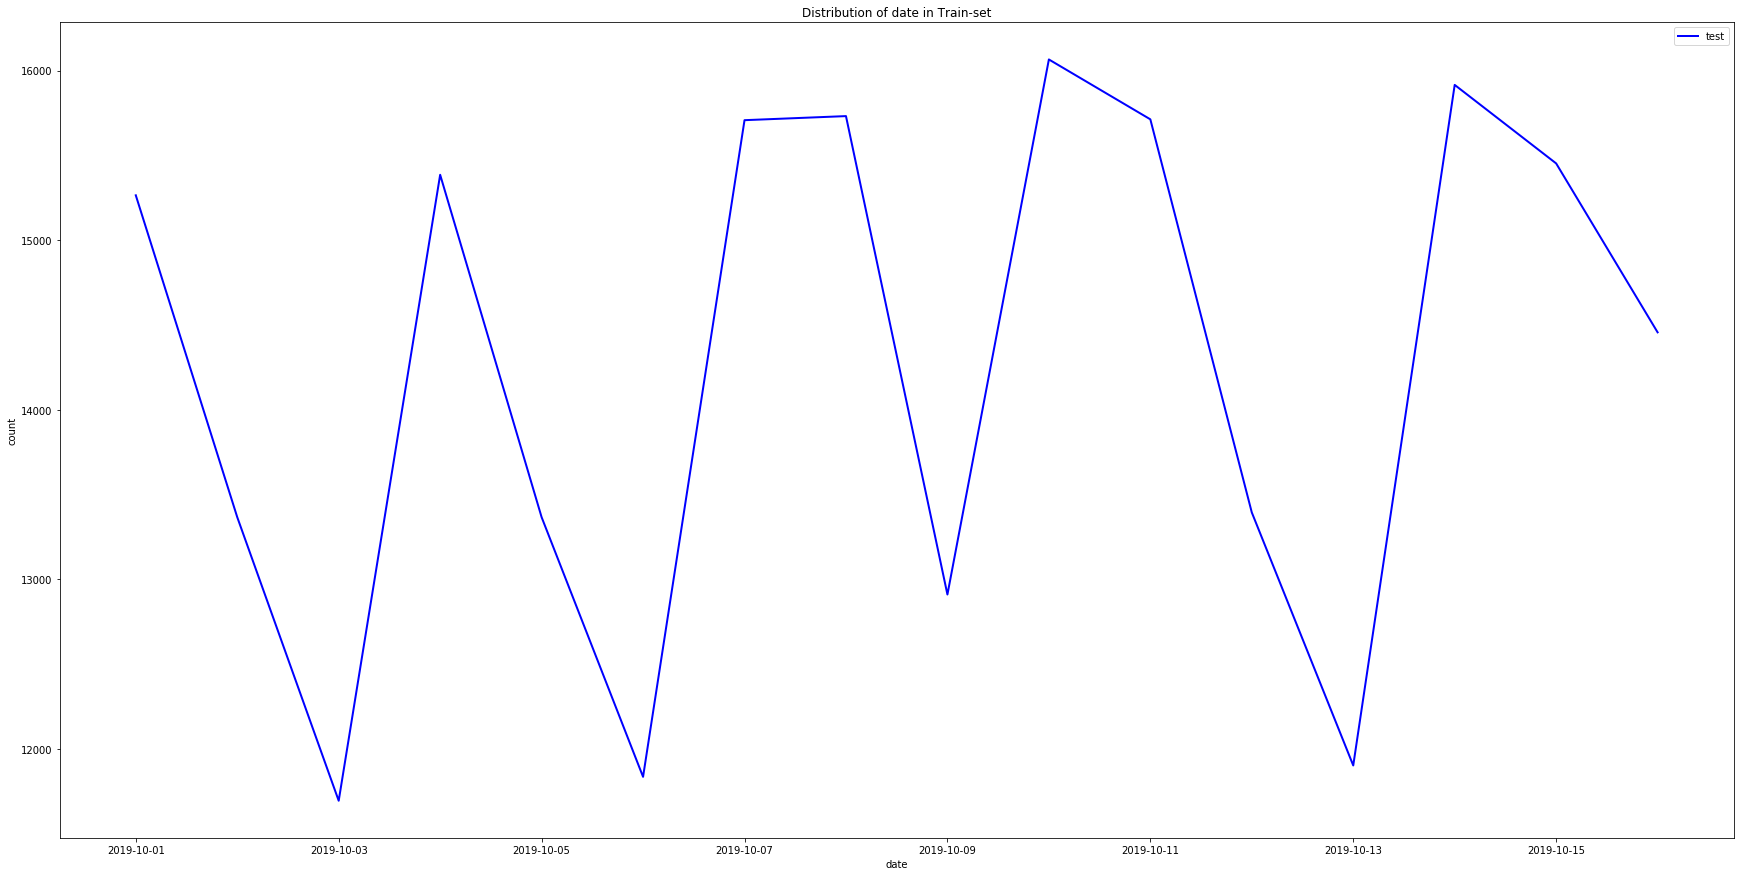

In [12]:
plt.figure(figsize=(30,15))
test['date'].value_counts().sort_index().plot(color="b", lw=2, label='test')
plt.legend() #label 표시
plt.xlabel("date") #x축 label
plt.ylabel("count") #y축 label
plt.title("Distribution of date in Train-set")

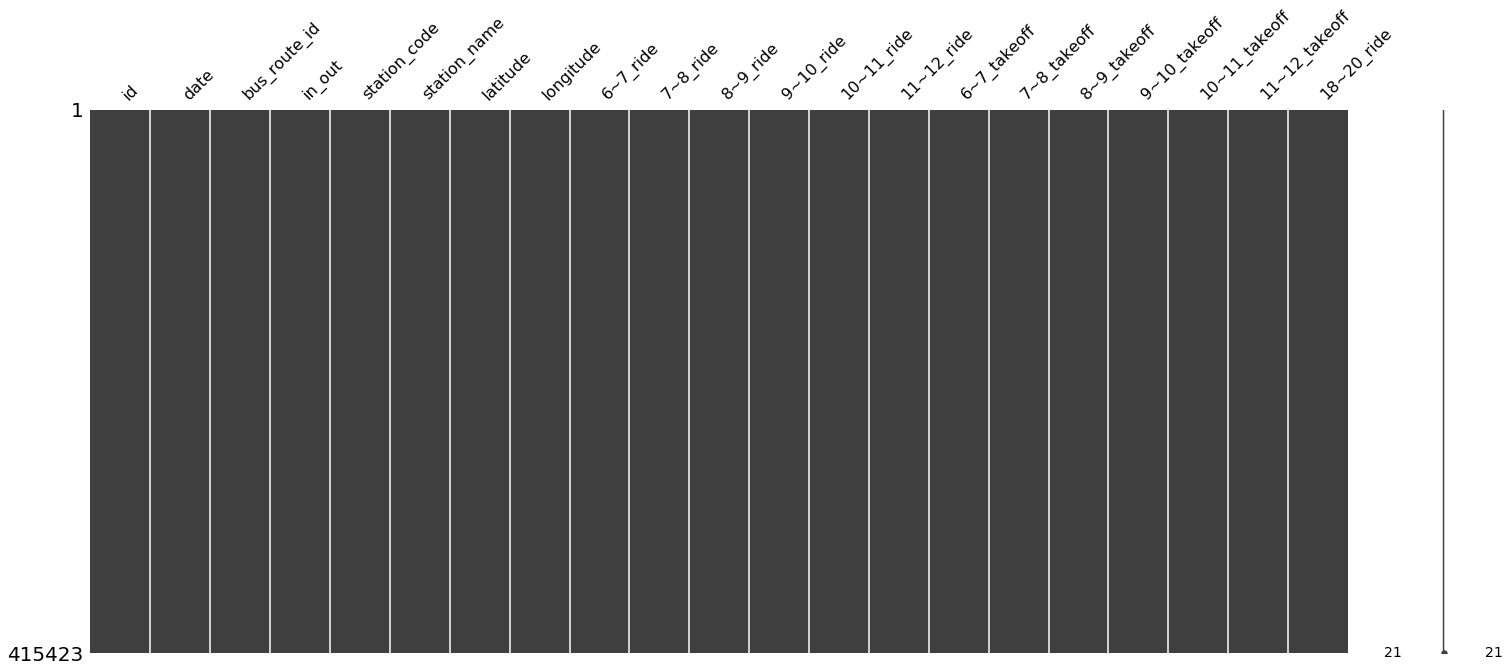

In [13]:
#train에 이상값 있나? #딱히 없음.
msno.matrix(train)

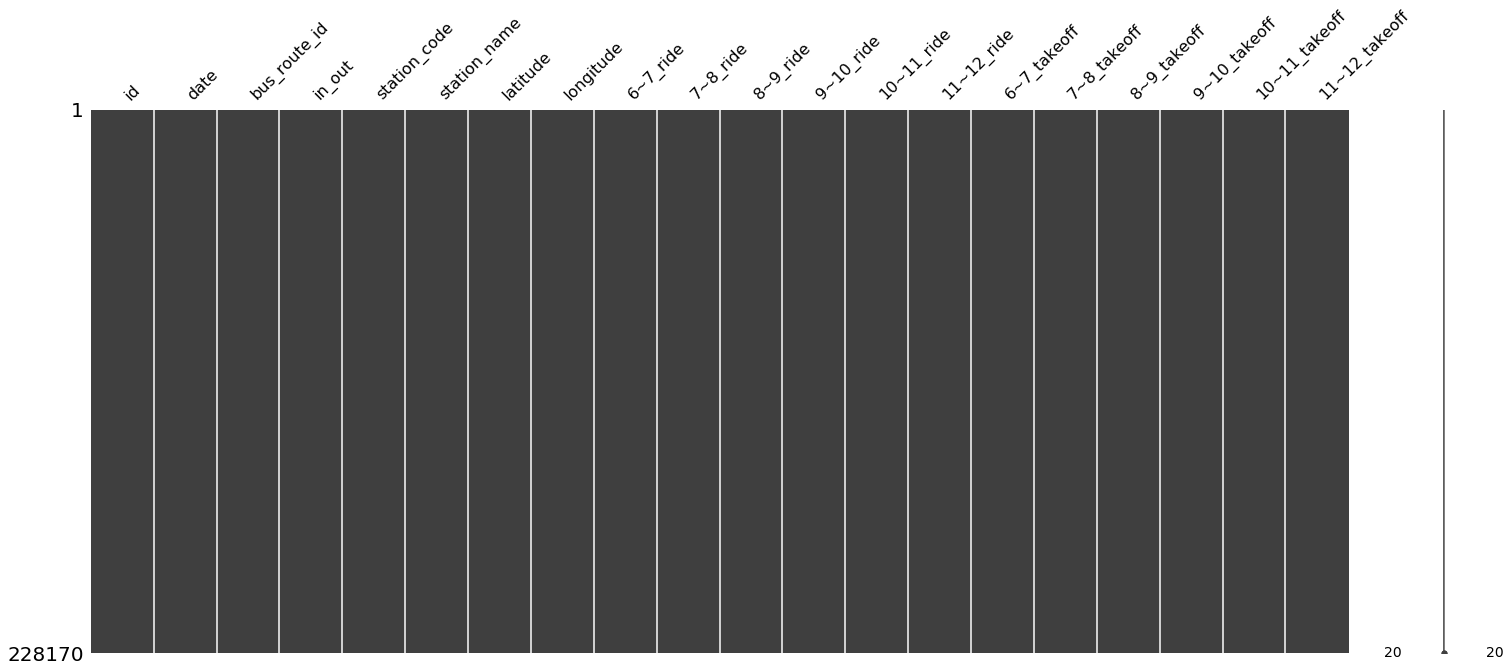

In [14]:
#test에 이상값 있나? #딱히 없음.
msno.matrix(test)

In [15]:
print(train.isnull().sum())
print("*"*30)
print(test.isnull().sum())

id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
18~20_ride       0
dtype: int64
******************************
id               0
date             0
bus_route_id     0
in_out           0
station_code     0
station_name     0
latitude         0
longitude        0
6~7_ride         0
7~8_ride         0
8~9_ride         0
9~10_ride        0
10~11_ride       0
11~12_ride       0
6~7_takeoff      0
7~8_takeoff      0
8~9_takeoff      0
9~10_takeoff     0
10~11_takeoff    0
11~12_takeoff    0
dtype: int64


In [16]:
# Target Variable의 분포를 살펴보자
target_col = '18~20_ride'

train[target_col].value_counts().sort_index()

0.0      296528
1.0       44268
2.0       23752
3.0       13560
4.0        8630
          ...  
240.0         1
241.0         1
245.0         1
265.0         1
272.0         1
Name: 18~20_ride, Length: 170, dtype: int64

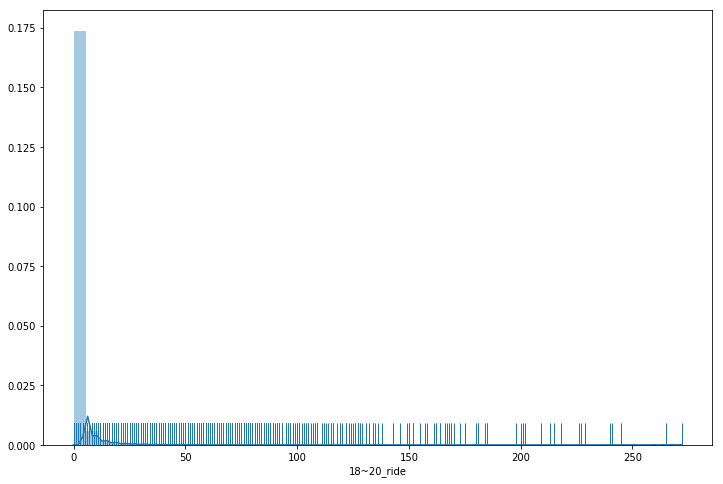

In [17]:
plt.figure(figsize=(12,8))
sns.distplot(train[target_col], rug=True) #0의 분포가 매우 높음. 매우 많다는 것을 확인할 수 있었음,

In [18]:
# 탑승 columns, 하차 columns
ride_columns = [col for col in test.columns if '_ride' in col]
take_off_columns = [col for col in test.columns if '_takeoff' in col] 

# Train의 승차 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns].sum(axis=1).agg(['min','max']) )

# Train의 하차 칼럼들의 rowsum
display( train[train[target_col]==0][take_off_columns].sum(axis=1).agg(['min','max']) )

# Train의 승하차 합 칼럼들의 rowsum
display( train[train[target_col]==0][ride_columns + take_off_columns].sum(axis=1).agg(['min','max']) )  
#6시~12시 내린 승객이 한명도 없고, 탄 승객이 없을 경우 해당 로우 삭제한다? Yes.
#특정날짜, 루트에도 없다? => 승차 하차 승객 0 일 수 있기 때문에 0이라는 피쳐 추가 가능할것 같다.

min      0.0
max    138.0
dtype: float64

min      0.0
max    165.0
dtype: float64

min      1.0
max    283.0
dtype: float64

In [19]:
#하나의 station name에 다수의 station_code 발견.
multi_station = train.groupby('station_name')['station_code'].nunique().sort_values()
multi_station[multi_station >= 7]

station_name
금악리    7
신안동    8
Name: station_code, dtype: int64

In [20]:
train[train['station_name'].isin(multi_station.index)][['station_code', 'station_name', 'latitude', 'longitude']]

#결국, station_code가 고유값임을 확인. 고유 정류장 기준을 station_name으로 설정하기에는 어려움.

,station_code,station_name,latitude,longitude
0,344,제주썬호텔,33.48990,126.49373
1,357,한라병원,33.48944,126.48508
2,432,정존마을,33.48181,126.47352
3,1579,제주국제공항(600번),33.50577,126.49252
4,1646,중문관광단지입구,33.25579,126.41260
...,...,...,...,...
415418,1129,한림환승정류장(한림리),33.41437,126.26336
415419,1564,제주시외버스터미널,33.49946,126.51479
415420,2322,해병부대,33.23100,126.26273
415421,3291,애월환승정류장(애월리),33.46483,126.31870


# 2. Data Cleansing / Feature Engineering

In [21]:
#요일의 영향을 받을것이라 생각했기 때문에 weekday 변수 만들어서 OneHotEncoding
train['date2'] = pd.to_datetime(train['date'])
train['weekday'] = train['date2'].dt.weekday

In [22]:
train = pd.get_dummies(train,columns=['weekday'])

In [23]:
test['date2'] = pd.to_datetime(test['date'])
test['weekday'] = test['date2'].dt.weekday
test = pd.get_dummies(test,columns=['weekday'])

del train['date2'] 
del test['date2']

In [24]:
train['in_out'] = train['in_out'].map({'시내':0,'시외':1})
test['in_out'] = test['in_out'].map({'시내':0,'시외':1})

In [25]:
train['68a']=train['6~7_ride']+train['7~8_ride'] # 6 ~ 8시 승차인원 (2시간단위로 묶어줌)
train['810a']=train['8~9_ride']+train['9~10_ride']
train['1012a']=train['10~11_ride']+train['11~12_ride']

train['68b']=train['6~7_takeoff']+train['7~8_takeoff'] # 6 ~ 8시 하차인원
train['810b']=train['8~9_takeoff']+train['9~10_takeoff']
train['1012b']=train['10~11_takeoff']+train['11~12_takeoff']

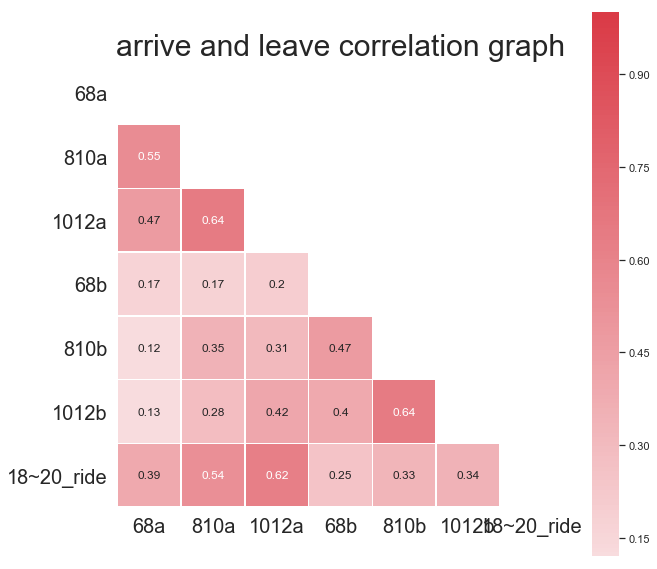

In [26]:
train22=train[['68a','810a','1012a','68b','810b','1012b','18~20_ride']]

cor=train22.corr()

sns.set(style="white")
mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(10,10))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":1},annot=True); #히트맵 생성
plt.xticks(size=20)
plt.yticks(size=20,rotation=0)
plt.title("arrive and leave correlation graph",size=30);

#그나마 18-20승차와 상관관계를 보이는 것은 오전 8-10시, 10-12시의 승차인원이 상관관계를 보임. 

In [27]:
#test도 같이 묶어줌.
test['68a']=test['6~7_ride']+test['7~8_ride']
test['810a']=test['8~9_ride']+test['9~10_ride']
test['1012a']=test['10~11_ride']+test['11~12_ride']

test['68b']=test['6~7_takeoff']+test['7~8_takeoff']
test['810b']=test['8~9_takeoff']+test['9~10_takeoff']
test['1012b']=test['10~11_takeoff']+test['11~12_takeoff']

In [28]:
# 해당 주요 장소의 임의 지역 위도, 경도 (baseline 참조)

jeju=(33.51411, 126.52969) # 제주 측정소 근처
gosan=(33.29382, 126.16283) #고산 측정소 근처
seongsan=(33.38677, 126.8802) #성산 측정소 근처
po=(33.24616, 126.5653) #서귀포 측정소 근처

#제주도 지역이 보일 수 있는 위치의 위도, 경도를 표시한 뒤, folium.Map에 변수로 넣고, map_osm에 할당
map_osm= folium.Map((33.399835, 126.506031),zoom_start=9)
mc = MarkerCluster()

mc.add_child( folium.Marker(location=jeju,popup='제주 측정소',icon=folium.Icon(color='red',icon='info-sign') ) ) #제주 측정소 마커 생성
map_osm.add_child(mc) #마커를 map_osm에 추가

mc.add_child( folium.Marker(location=gosan,popup='고산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=seongsan,popup='성산 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc) 

mc.add_child( folium.Marker(location=po,popup='서귀포 측정소',icon=folium.Icon(color='red',icon='info-sign') ) )
map_osm.add_child(mc)

In [29]:
#정류장의 위치만 확인하기 위해 groupby를 실행함
data=train[['latitude','longitude','station_name']].drop_duplicates(keep='first')

data2=data.groupby(['station_name'])['latitude','longitude'].mean()

data2.to_csv("folium.csv")

data2=pd.read_csv("folium.csv")

#정류장의 대략적인 위치를 확인하기 위하여, folium map에 해당 정류장을 표시
for row in data2.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude], popup=row.station_name)) #마커 생성
    map_osm.add_child(mc) #마커를 map_osm에 추가
    
map_osm

In [30]:
#catergorical 변수 : bus_route_id , station_code, 'station_name' (label_encoder 적용)

lbl = LabelEncoder()

cat_cols = ['bus_route_id', 'station_code','station_name']

for col in tqdm_notebook(cat_cols):
    lbl.fit(train[col])
    train[col] = lbl.transform(train[col])
    
for col in tqdm_notebook(cat_cols):
    lbl.fit(test[col])
    test[col] = lbl.transform(test[col])

In [31]:
train = train.drop(['latitude','longitude'], axis=1)
test = test.drop(['latitude','longitude'], axis=1)

In [48]:
#3가지 시간대로 나눔
dawn_ride_cols, dawn_takoff_cols = ['6~7_ride','7~8_ride'], ['6~7_takeoff','7~8_takeoff']
morning_ride_cols, morning_takeoff_cols = ['8~9_ride','9~10_ride'], ['8~9_takeoff','9~10_takeoff']
noon_ride_cols, noon_takeoff_cols = ['10~11_ride','11~12_ride'], ['10~11_takeoff','11~12_takeoff']

# df 가공
def modify_terms(df):
    # ride columns
    df['dawn_ride'] = df[dawn_ride_cols].sum(axis=1)
    df['morning_ride'] = df[morning_ride_cols].sum(axis=1)
    df['noon_ride'] = df[noon_ride_cols].sum(axis=1)
    
    # takeoff columns
    df['dawn_takeoff'] = df[dawn_takoff_cols].sum(axis=1)
    df['morning_takeoff'] = df[morning_takeoff_cols].sum(axis=1)
    df['noon_takeoff'] = df[noon_takeoff_cols].sum(axis=1)
    
    # drop columns
    drop_cols = dawn_ride_cols + morning_ride_cols + noon_ride_cols + dawn_takoff_cols + morning_takeoff_cols + noon_takeoff_cols
    df = df.drop(drop_cols, 1)
    
    return df
    

train = modify_terms(train)
test = modify_terms(test)

# 탑승
train['avg_dawn_ride'] = train.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
train['avg_morning_ride'] = train.groupby(['date','bus_route_id'])['morning_ride'].transform('mean') 
train['avg_noon_ride'] = train.groupby(['date','bus_route_id'])['noon_ride'].transform('mean') 

test['avg_dawn_ride'] = test.groupby(['date','bus_route_id'])['dawn_ride'].transform('mean') 
test['avg_morning_ride'] = test.groupby(['date','bus_route_id'])['morning_ride'].transform('mean') 
test['avg_noon_ride'] = test.groupby(['date','bus_route_id'])['noon_ride'].transform('mean') 

# 하차
train['avg_dawn_takeoff'] = train.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 
train['avg_morning_takeoff'] = train.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean') 
train['avg_noon_takeoff'] = train.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean') 

test['avg_dawn_takeoff'] = test.groupby(['date','bus_route_id'])['dawn_takeoff'].transform('mean') 
test['avg_morning_takeoff'] = test.groupby(['date','bus_route_id'])['morning_takeoff'].transform('mean') 
test['avg_noon_takeoff'] = test.groupby(['date','bus_route_id'])['noon_takeoff'].transform('mean') 

In [49]:
#datetime 변환
weather['date'] = pd.to_datetime( weather['date'] )

#train/test기간
weather = weather[(weather['date']>='2019-08-31 00:00:00')&(weather['date']<='2019-10-16 23:00:00')].reset_index(drop=True)

weather['hour'] = weather['date'].dt.hour
weather['date'] = weather['date'].dt.date

# prevday_weather = weather.groupby('date')[['precipitation','temp']].sum().reset_index()
# prevday_weather.columns = ['prev_date', 'prevday_precipitation', 'temp']

# 해당 날짜의 강수량
weather = weather[weather['hour']<=12].reset_index(drop=True)


# 00~15시까지의 강수량, 온도를 피쳐로 사용
weather = weather.groupby('date')[['precipitation','temp']].sum().reset_index()

# prevday_weather['prev_date'] = pd.to_datetime( prevday_weather['prev_date'] )
weather['date'] = pd.to_datetime( weather['date'] )

In [50]:
weather

,date,precipitation,temp
0,2019-08-31,0.0,302.2
1,2019-09-01,0.0,314.6
2,2019-09-02,26.8,296.4
3,2019-09-03,12.9,315.4
4,2019-09-04,36.3,318.3
5,2019-09-05,0.1,330.6
6,2019-09-06,0.0,348.3
7,2019-09-07,44.5,362.4
8,2019-09-08,0.2,323.5
9,2019-09-09,21.9,333.2


In [34]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

In [51]:
# Train/Test-set에 대하여 이전날 날짜 컬럼 만들어줌

# train['prev_date'] = train['date'] - pd.Timedelta('1 day')
# test['prev_date'] = test['date'] - pd.Timedelta('1 day')

# train = pd.merge(train, prevday_weather , on ='prev_date',  how ='left')
# test = pd.merge(test, prevday_weather , on ='prev_date',how ='left')

# # prev_date 칼럼은 삭제
# train = train.drop('prev_date',1)
# test = test.drop('prev_date',1)


# 해당날짜에 대하여 Train/Test-set과 강수량 정보를 join
train = pd.merge( train, weather , on ='date', how='left')
test = pd.merge( test, weather , on ='date', how='left')

In [52]:
train

,id,date,bus_route_id,in_out,station_code,station_name,18~20_ride,weekday_0,weekday_1,weekday_2,...,morning_takeoff,noon_takeoff,avg_dawn_ride,avg_morning_ride,avg_noon_ride,avg_dawn_takeoff,avg_morning_takeoff,avg_noon_takeoff,precipitation_y,temp
0,0,2019-09-01,0,1,321,1481,0.0,0,0,0,...,0.0,0.0,1.280000,2.24,2.72,0.160000,0.320000,1.88,0.0,314.6
1,1,2019-09-01,0,1,334,1822,5.0,0,0,0,...,0.0,0.0,1.280000,2.24,2.72,0.160000,0.320000,1.88,0.0,314.6
2,2,2019-09-01,0,1,407,1406,2.0,0,0,0,...,0.0,0.0,1.280000,2.24,2.72,0.160000,0.320000,1.88,0.0,314.6
3,3,2019-09-01,0,0,1440,1431,53.0,0,0,0,...,0.0,0.0,1.280000,2.24,2.72,0.160000,0.320000,1.88,0.0,314.6
4,4,2019-09-01,0,0,1501,1575,0.0,0,0,0,...,1.0,0.0,1.280000,2.24,2.72,0.160000,0.320000,1.88,0.0,314.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,415418,2019-09-30,612,0,1042,1843,0.0,1,0,0,...,0.0,0.0,1.111111,0.00,0.00,0.444444,0.444444,0.00,0.0,306.8
415419,415419,2019-09-30,612,0,1425,1475,0.0,1,0,0,...,0.0,0.0,1.111111,0.00,0.00,0.444444,0.444444,0.00,0.0,306.8
415420,415420,2019-09-30,612,0,2133,1878,0.0,1,0,0,...,0.0,0.0,1.111111,0.00,0.00,0.444444,0.444444,0.00,0.0,306.8
415421,415421,2019-09-30,612,0,3021,1093,0.0,1,0,0,...,0.0,0.0,1.111111,0.00,0.00,0.444444,0.444444,0.00,0.0,306.8


In [53]:
target_col = '18~20_ride'
drop_cols = ['date','id', target_col]
train_label = train[target_col]

#test 예측해야할 빈 컬럼 생성
test[target_col] = np.NaN

# 3. Modeling

In [54]:
# 각 모델에 대한 oof 정의
lgbm_oof_train = np.zeros((train.shape[0]))
lgbm_oof_test = np.zeros((test.shape[0]))

# 모델에 쓰일 parameter 정의하기
n_splits= 5
NUM_BOOST_ROUND = 100000
SEED = 777
lgbm_param = {'objective':'rmse',
              'boosting_type': 'gbdt',
              'random_state':777,
              'learning_rate':0.1,
              'subsample':0.7,
              'tree_learner': 'serial',
              'colsample_bytree':0.78,
              'early_stopping_rounds':50,
              'subsample_freq': 1,
              'reg_lambda':7,
              'reg_alpha': 5,
              'num_leaves': 96,
              'seed' : SEED
            }

# Kfold 정의
kfolds = KFold(n_splits=n_splits, random_state=1993, shuffle=True)

# Fold별로 학습진행
for ind, (trn_ind, val_ind) in tqdm_notebook( enumerate( kfolds.split( X = train, y = train_label ) ) ):
    
    # Train/Valid-set을 정의하기
    X_train , y_train = train.iloc[trn_ind].drop(drop_cols, 1), train_label[trn_ind]
    X_valid , y_valid = train.iloc[val_ind].drop(drop_cols, 1), train_label[val_ind]
    
    
    
    # (5) Light GBM
    print("---TRAINING LIGHT GBM---")
    # dtrain/dvalid 정의
    dtrain = lgbm.Dataset(X_train, y_train)
    dvalid = lgbm.Dataset(X_valid, y_valid)
    
    # model 정의&학습
    model = lgbm.train(lgbm_param , dtrain, NUM_BOOST_ROUND, 
                       valid_sets=(dtrain, dvalid), 
                       valid_names=('train','valid'), 
                       verbose_eval= 100)
    
    # local_valid/local_test에 대한 예측
    lgbm_valid_pred = model.predict(X_valid)
    lgbm_test_pred = model.predict(test.drop(drop_cols, 1))
        
    lgbm_oof_train[val_ind] = lgbm_valid_pred
    lgbm_oof_test += lgbm_test_pred/ n_splits #Fold한 결과 앙상블 (평균)

---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.20638	valid's rmse: 2.75304
[200]	train's rmse: 1.96046	valid's rmse: 2.68776
[300]	train's rmse: 1.80957	valid's rmse: 2.65303
[400]	train's rmse: 1.69911	valid's rmse: 2.6357
[500]	train's rmse: 1.61207	valid's rmse: 2.61821
[600]	train's rmse: 1.53996	valid's rmse: 2.60608
[700]	train's rmse: 1.48134	valid's rmse: 2.59908
[800]	train's rmse: 1.42608	valid's rmse: 2.59349
[900]	train's rmse: 1.38035	valid's rmse: 2.5903
[1000]	train's rmse: 1.33845	valid's rmse: 2.58854
[1100]	train's rmse: 1.29915	valid's rmse: 2.58513
[1200]	train's rmse: 1.26313	valid's rmse: 2.58311
[1300]	train's rmse: 1.23018	valid's rmse: 2.58235
[1400]	train's rmse: 1.19925	valid's rmse: 2.58017
Early stopping, best iteration is:
[1424]	train's rmse: 1.19171	valid's rmse: 2.57934
---TRAINING LIGHT GBM---
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.24723	valid's rms

In [55]:
# import math
# from sklearn.metrics import mean_squared_error
# print(f"<Light-GBM> OVERALL RMSE: {math.sqrt( mean_squared_error( train_label, lgbm_valid_pred ) )}")

In [56]:
# lgb_train = lgbm.Dataset(X_train,label=y_train)

# lgb_param = {"objective":"regression",
#              "metrics":"mae",
#              "learning_rate":0.01}

# print("cv start")
# cv_result = lgbm.cv(lgb_param,
#                    lgb_train,
#                    num_boost_round=10000,
#                    nfold=5,
#                    early_stopping_rounds=10,
#                    stratified=False,
#                    verbose_eval=10,
#                    seed = 777)

# print("train start")
# lgb_model = lgbm.train(lgb_param,
#                       lgb_train,
#                       num_boost_round = len(cv_result["l1-mean"]))

In [57]:
#전체 데이터로 적용
target = '18~20_ride'
X_train=train.iloc[:,2:]
y_train=train[target]

X_test=test.iloc[:,2:]

X_train.drop('18~20_ride', axis=1, inplace=True)
X_test.drop('18~20_ride', axis=1, inplace=True)

X_train.shape, y_train.shape, X_test.shape

((415423, 35), (415423,), (228170, 35))

In [58]:
X_train.columns
X_test

,bus_route_id,in_out,station_code,station_name,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,...,morning_takeoff,noon_takeoff,avg_dawn_ride,avg_morning_ride,avg_noon_ride,avg_dawn_takeoff,avg_morning_takeoff,avg_noon_takeoff,precipitation_y,temp
0,0,1,322,1478,0,1,0,0,0,0,...,0.0,1.0,1.586207,2.034483,3.862069,0.103448,0.931034,1.103448,5.8,309.9
1,0,1,335,1817,0,1,0,0,0,0,...,0.0,0.0,1.586207,2.034483,3.862069,0.103448,0.931034,1.103448,5.8,309.9
2,0,1,408,1402,0,1,0,0,0,0,...,0.0,0.0,1.586207,2.034483,3.862069,0.103448,0.931034,1.103448,5.8,309.9
3,0,0,1433,1427,0,1,0,0,0,0,...,0.0,0.0,1.586207,2.034483,3.862069,0.103448,0.931034,1.103448,5.8,309.9
4,0,0,1483,475,0,1,0,0,0,0,...,1.0,0.0,1.586207,2.034483,3.862069,0.103448,0.931034,1.103448,5.8,309.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228165,600,0,731,87,0,0,1,0,0,0,...,0.0,0.0,1.285714,0.000000,0.000000,0.857143,0.428571,0.000000,0.0,228.9
228166,600,0,986,1084,0,0,1,0,0,0,...,0.0,0.0,1.285714,0.000000,0.000000,0.857143,0.428571,0.000000,0.0,228.9
228167,600,0,1035,1838,0,0,1,0,0,0,...,0.0,0.0,1.285714,0.000000,0.000000,0.857143,0.428571,0.000000,0.0,228.9
228168,600,0,1418,1471,0,0,1,0,0,0,...,0.0,0.0,1.285714,0.000000,0.000000,0.857143,0.428571,0.000000,0.0,228.9


# 4. Save Prediction Result 

In [59]:
#test pred
test['18~20_ride'] = model.predict(X_test)
test[['id','18~20_ride']].to_csv("submission.csv",index=False) # id와 18~20_ride만 선택 후 csv 파일로 저장.